# 2D trajectory plot

In [4]:
%reload_ext autoreload
%autoreload 2

# === Imports & helpers ===
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Tuple, Union
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 统一列名（去空格、小写、映射常见字段）
_COL_MAP = {
    "uwi": "uwi",
    "alternateuwi": "alternateuwi",
    "wellname": "wellname",
    "w": "w",                  # ← 用它来分井
    "well": "well",
    "boreholename": "boreholename",
    "name": "name",
    "md": "md",
    "tvd": "tvd",
    "inc": "inc",
    "azm": "azm",
    "dx": "dx",
    "dy": "dy",
    "x": "x",
    "y": "y",
    "northref": "northref",
    "compmethod": "compmethod",
    "northdecl": "northdecl",
    "z": "z",
    "status": "status",
}

def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = []
    for c in df.columns:
        k = re.sub(r"\s+", "", str(c)).lower()
        new_cols.append(_COL_MAP.get(k, k))
    out = df.copy()
    out.columns = new_cols
    return out

def _coerce_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _reconstruct_xy(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """
    根据 x,y 或 dx,dy 生成平面轨迹。
    - 若 x,y 足够 → 直接返回
    - 否则用 dx,dy 做累积和；起点优先用首个有效 x/y，否则 (0,0)
    """
    # 内部按 MD 排序（若存在）
    if "md" in df.columns:
        df = df.sort_values("md", kind="mergesort")

    x = df["x"].to_numpy() if "x" in df.columns else np.full(len(df), np.nan)
    y = df["y"].to_numpy() if "y" in df.columns else np.full(len(df), np.nan)

    if np.isfinite(x).sum() >= 2 and np.isfinite(y).sum() >= 2:
        return x, y

    if "dx" in df.columns and "dy" in df.columns:
        dx = pd.to_numeric(df["dx"], errors="coerce").to_numpy()
        dy = pd.to_numeric(df["dy"], errors="coerce").to_numpy()
        x0 = float(x[np.isfinite(x)][0]) if np.isfinite(x).any() else 0.0
        y0 = float(y[np.isfinite(y)][0]) if np.isfinite(y).any() else 0.0
        X = x0 + np.nancumsum(np.nan_to_num(dx, nan=0.0))
        Y = y0 + np.nancumsum(np.nan_to_num(dy, nan=0.0))
        return X, Y

    raise ValueError("既无有效 x,y，也无 dx,dy，无法构建轨迹。")


In [5]:
def plot_wells_by_w(
    source: Union[str, Path, pd.DataFrame],
    *,
    sheet: Union[str, int, None] = None,
    title: str | None = None,
    annotate_endpoints: bool = True,
    ax: plt.Axes | None = None,
) -> Tuple[plt.Figure, plt.Axes, Dict[str, pd.DataFrame]]:
    """
    从单个 sheet 的数据中，按列 'w'（如 5H、3H、11H…）分组绘制井眼平面轨迹。
    source: Excel 路径（str/Path）或已读入的 DataFrame
    sheet : sheet 名称或索引（source 为路径时可用；默认第一个）
    """
    # 读取数据
    if isinstance(source, (str, Path)):
        df = pd.read_excel(source, sheet_name=sheet if sheet is not None else 0, engine="openpyxl")
    elif isinstance(source, pd.DataFrame):
        df = source.copy()
    else:
        raise TypeError("source 必须是 Excel 路径或 pandas.DataFrame。")

    # 标准化列名与类型
    df = _normalize_columns(df)
    df = _coerce_numeric(df, ["md", "tvd", "inc", "azm", "dx", "dy", "x", "y", "z"])

    # 分组列：w
    if "w" not in df.columns:
        raise ValueError("未找到列 'w'（用于区分井）。请检查表头。")

    # 绘图准备
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig = ax.figure

    cleaned: Dict[str, pd.DataFrame] = {}
    colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [f"C{i}" for i in range(10)])

    for i, (w_val, dfg) in enumerate(df.groupby("w", sort=False)):
        if dfg.empty:
            continue

        # 井内排序
        if "md" in dfg.columns:
            dfg = dfg.sort_values("md", kind="mergesort")

        # 构建轨迹
        try:
            X, Y = _reconstruct_xy(dfg)
        except Exception as e:
            print(f"[WARN] 井 {w_val} 跳过：{e}")
            continue

        mask = np.isfinite(X) & np.isfinite(Y)
        if mask.sum() < 2:
            print(f"[WARN] 井 {w_val} 跳过：有效点不足。")
            continue

        xx, yy = X[mask], Y[mask]
        dclean = dfg.loc[mask].copy()
        dclean["x_plan"] = xx
        dclean["y_plan"] = yy
        cleaned[str(w_val)] = dclean

        color = colors[i % len(colors)]
        label = str(w_val)
        ax.plot(xx, yy, lw=2.0, color=color, label=label)
        if annotate_endpoints:
            ax.scatter([xx[-1]], [yy[-1]], s=20, color=color, zorder=5)
            ax.annotate(
                label,
                xy=(xx[-1], yy[-1]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.6),
            )

    if not cleaned:
        raise ValueError("清洗后无可绘制的井轨迹。")

    ax.set_xlabel("East kb ft")
    # label rotate 90 degrees
    ax.set_ylabel("North kb ft")
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, ls="--", alpha=0.4)

    ax.ticklabel_format(style='plain', useOffset=False, axis='both')
    ax.set_yticks([10620000, 10622000,  10624000, 10626000, 10628000])
    ax.set_xticks([2150000,  2152000, 2154000, 2156000])
    # ax.set_title(title or "Well Trajectories by 'w'")
    # leg = ax.legend(loc="best", frameon=True)
    # leg.set_zorder(6)
    # plt.tight_layout()

    return fig, ax, cleaned

# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
    #   'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

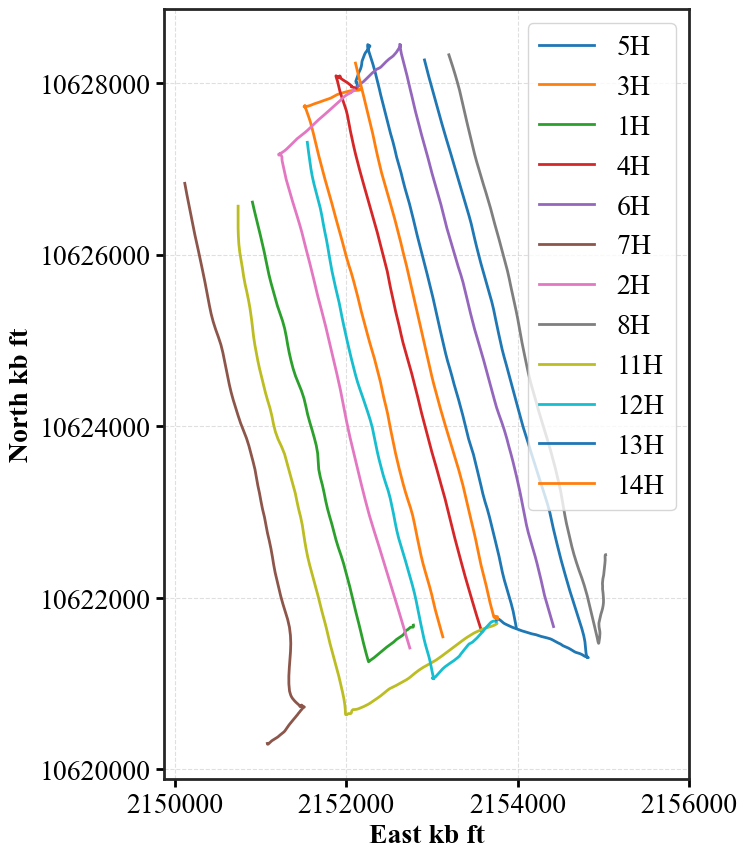

{'5H': 159,
 '3H': 154,
 '1H': 166,
 '4H': 160,
 '6H': 155,
 '7H': 190,
 '2H': 128,
 '8H': 157,
 '11H': 195,
 '12H': 194,
 '13H': 203,
 '14H': 191}

In [57]:
# 设置 Excel 路径（只有一个 sheet）
excel_path = r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/well_trajectory.xlsx"  # ←←← 改成你的文件路径

fig, ax, cleaned = plot_wells_by_w(
    excel_path,
    sheet=0,                 # 单表默认 0；也可写具体的 sheet 名
    title=None,
    annotate_endpoints=False  # 末端标注井名
)
# ax.set_title("Well Trajectories by 'w'")
ax.legend()
plt.show()

# 可选：看一下每口井清洗后的点数
{w: len(dfw) for w, dfw in cleaned.items()}


# 3D trajectory plot

In [25]:
# === 3D helpers (append to your notebook) ===
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (for side effects)
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# 如果你已经有 _normalize_columns / _coerce_numeric / _reconstruct_xy，就不用重复定义
def _reconstruct_z(df: pd.DataFrame) -> np.ndarray:
    """
    生成 Z 轴：
      1) 首选列 'z'
      2) 其次 'tvd'
      3) 否则用 md + inc 估算：Δz ≈ Δmd * cos(inc) （inc 以“偏离垂直”的角度计，常见定义）
    """
    df = df.copy()
    if "md" in df.columns:
        df = df.sort_values("md", kind="mergesort")

    # 优先 z / tvd
    for key in ("z", "tvd"):
        if key in df.columns and pd.to_numeric(df[key], errors="coerce").notna().sum() >= 2:
            Z = pd.to_numeric(df[key], errors="coerce").to_numpy()
            return Z*-1

    # 估算：用 md + inc
    if "md" in df.columns and "inc" in df.columns:
        md = pd.to_numeric(df["md"], errors="coerce").to_numpy()
        inc = pd.to_numeric(df["inc"], errors="coerce").to_numpy()  # deg from vertical
        mask = np.isfinite(md) & np.isfinite(inc)
        if mask.sum() >= 2:
            md = md[mask]
            inc = inc[mask]
            # 用分段差分 + 中点倾角估算垂向位移
            dmd = np.diff(md)
            inc_mid = np.deg2rad((inc[:-1] + inc[1:]) / 2.0)
            dz = dmd * np.cos(inc_mid)  # 近似：沿井斜段的垂向分量
            Z = np.empty_like(md)
            Z[0] = 0.0
            Z[1:] = np.cumsum(dz)
            # 若 df 还有首个有效 z/tvd，则作为起点
            z0 = None
            for key in ("z", "tvd"):
                if key in df.columns:
                    v = pd.to_numeric(df[key], errors="coerce")
                    if v.notna().any():
                        z0 = float(v.dropna().iloc[0])
                        break
            if z0 is not None:
                Z = Z - Z[0] + z0
            # 映射回原行顺序（保持与 X/Y 对齐更简单：外部用 mask/排序后的 df）
            return Z
    raise ValueError("无可用的 z/tvd，且 md/inc 无法可靠估算 Z。")


def _set_3d_plain_ticks(ax: plt.Axes) -> None:
    """关闭 3D 三轴的科学计数法与偏移。"""
    fmt = mticker.ScalarFormatter(useOffset=False)
    fmt.set_scientific(False)
    ax.xaxis.set_major_formatter(fmt)
    ax.yaxis.set_major_formatter(fmt)
    ax.zaxis.set_major_formatter(fmt)


def _update_box_aspect(ax: plt.Axes, xyz_minmax) -> None:
    """根据数据范围设置等比例盒体（需要 Matplotlib >=3.3）。"""
    (xmin, xmax), (ymin, ymax), (zmin, zmax) = xyz_minmax
    dx = xmax - xmin
    dy = ymax - ymin
    dz = zmax - zmin
    # 防止零范围
    dx = dx or 1.0
    dy = dy or 1.0
    dz = dz or 1.0
    try:
        ax.set_box_aspect((dx, dy, dz))
    except Exception:
        pass


In [55]:
def plot_wells_3d_by_w(
    source,
    *,
    sheet=None,
    title: str | None = None,
    annotate_endpoints: bool = True,
    ax: plt.Axes | None = None,
    invert_z: bool = True,   # True=井口在上（深度越大越向下）
):
    """
    3D 井轨迹图（按列 'w' 分组）。沿用你已有的平面重建方法：
      - X,Y：优先 x,y；否则 dx,dy 累积（先按 md 升序）
      - Z  ：优先 z；其次 tvd；否则 md+inc 估算（Δz≈Δmd*cos(inc)）
    """
    # 读取/准备数据
    if isinstance(source, (str, Path)):
        df = pd.read_excel(source, sheet_name=sheet if sheet is not None else 0, engine="openpyxl")
    elif isinstance(source, pd.DataFrame):
        df = source.copy()
    else:
        raise TypeError("source 必须为 Excel 路径或 DataFrame")

    # 需要你 notebook 里已有的两个函数，若没有请把它们粘上来
    df = _normalize_columns(df)
    df = _coerce_numeric(df, ["md", "tvd", "inc", "azm", "dx", "dy", "x", "y", "z"])

    if "w" not in df.columns:
        raise ValueError("未找到列 'w'。")

    # 准备画布
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
    else:
        fig = ax.figure

    cleaned = {}
    # 用来统计总体范围，便于等比例
    Xmins, Xmaxs, Ymins, Ymaxs, Zmins, Zmaxs = [], [], [], [], [], []

    colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [f"C{i}" for i in range(10)])

    for i, (w_val, dfg) in enumerate(df.groupby("w", sort=False)):
        if dfg.empty:
            continue

        # 井内按 md 排序
        if "md" in dfg.columns:
            dfg = dfg.sort_values("md", kind="mergesort")

        # 平面
        X, Y = _reconstruct_xy(dfg)
        # 深度
        try:
            Z = _reconstruct_z(dfg)
        except Exception as e:
            print(f"[WARN] 井 {w_val} 无 Z：{e}。仅用 XY，Z=NaN 跳过。")
            continue

        mask = np.isfinite(X) & np.isfinite(Y) & np.isfinite(Z)
        if mask.sum() < 2:
            print(f"[WARN] 井 {w_val} 有效 3D 点不足。")
            continue

        xx, yy, zz = X[mask], Y[mask], Z[mask]
        dclean = dfg.loc[mask].copy()
        dclean["x_plan"], dclean["y_plan"], dclean["z_depth"] = xx, yy, zz
        cleaned[str(w_val)] = dclean

        color = colors[i % len(colors)]
        ax.plot(xx, yy, zz, lw=2.0, label=str(w_val), color=color)
        if annotate_endpoints:
            ax.scatter([xx[-1]], [yy[-1]], [zz[-1]], s=20, color=color)
            ax.text(xx[-1], yy[-1], zz[-1], f" {w_val}", fontsize=15)

        # 记录范围
        Xmins.append(np.nanmin(xx)); Xmaxs.append(np.nanmax(xx))
        Ymins.append(np.nanmin(yy)); Ymaxs.append(np.nanmax(yy))
        Zmins.append(np.nanmin(zz)); Zmaxs.append(np.nanmax(zz))

    if not cleaned:
        raise ValueError("没有可绘制的 3D 轨迹。")

    # 轴样式
    ax.set_xlabel("East kb ft")
    ax.set_ylabel("North kb ft")
    ax.set_zlabel("Z ft")
    if invert_z:
        ax.invert_zaxis()  # 井口在上

    # 关闭科学计数法
    _set_3d_plain_ticks(ax)

    # 等比例盒体
    xyz_minmax = ((min(Xmins), max(Xmaxs)),
                  (min(Ymins), max(Ymaxs)),
                  (min(Zmins), max(Zmaxs)))
    _update_box_aspect(ax, xyz_minmax)

    ax.grid(True)
    # ax.set_title(title or "3D Well Trajectories by 'w'")
    ax.legend(loc="best")
    ax.ticklabel_format(style='plain', useOffset=False, axis='both')
    ax.set_yticks([10620000, 10628000])
    ax.set_xticks([2151000,   2155000])
    ax.set_zticks([0,4000,8000,12000])  # 根据你的数据调整
    plt.tight_layout()
    return fig, ax, cleaned


In [50]:
%matplotlib widget

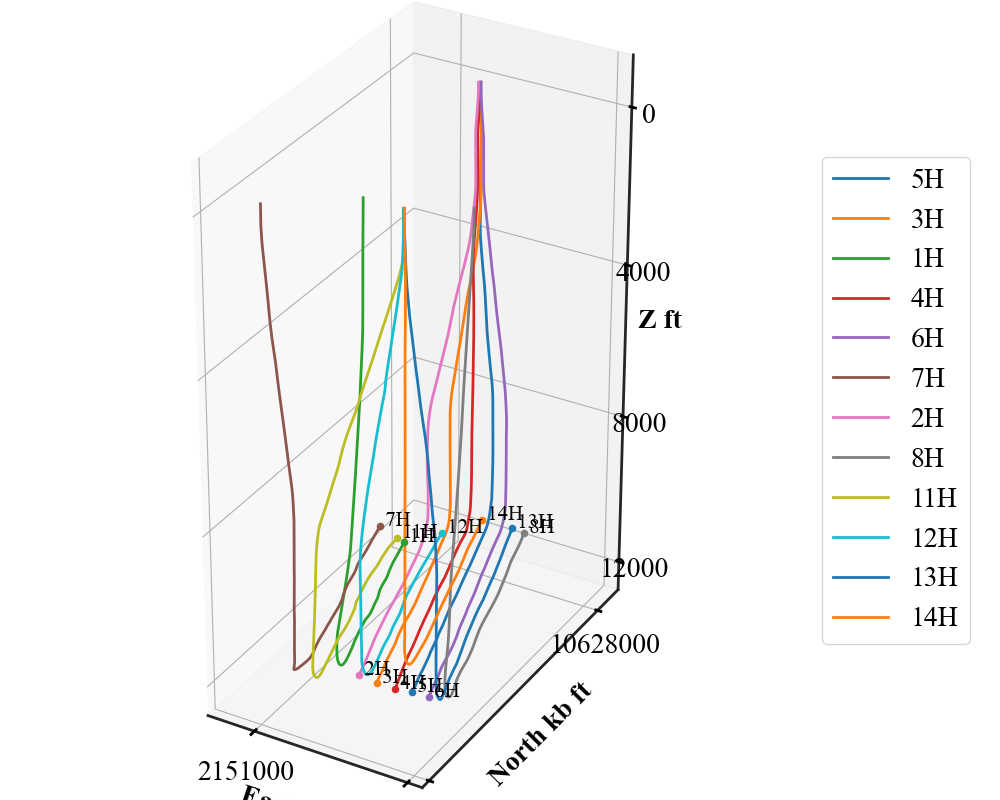

In [56]:
excel_path = r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/well_trajectory.xlsx"  # ←←← 改成你的文件路径

fig3d, ax3d, cleaned3d = plot_wells_3d_by_w(
    excel_path,
    sheet=0,                 # 单表：0；或写具体名字
    # title="3D Well trajectories (by 'w')",
    annotate_endpoints=True,
    invert_z=True            # True=井口在上；想反过来就设 False
)
leg = ax3d.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
fig3d.subplots_adjust(right=0.80)
plt.show()


interactive(children=(IntSlider(value=20, description='Elev', max=90, min=-90), IntSlider(value=-60, descripti…

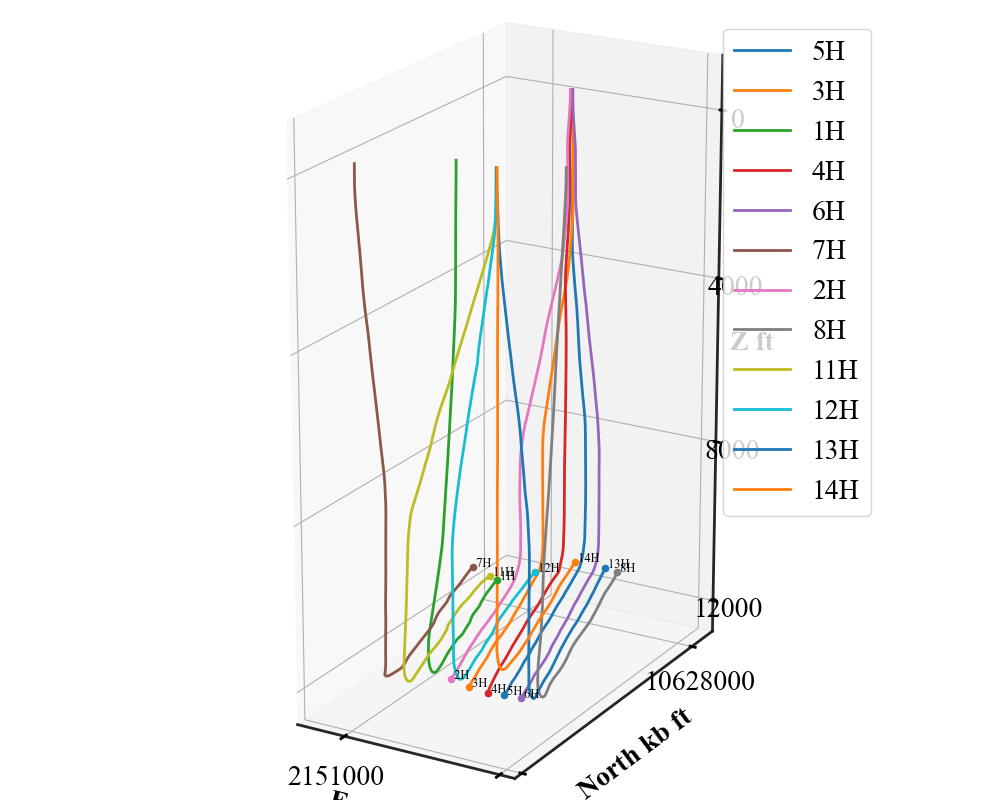

In [52]:
import ipywidgets as W

def update(elev=20, azim=-60, ortho=False):
    ax3d.view_init(elev=elev, azim=azim)
    ax3d.set_proj_type('ortho' if ortho else 'persp')
    fig3d.canvas.draw_idle()

W.interact(
    update,
    elev=W.IntSlider(value=20, min=-90, max=90, step=1, description='Elev'),
    azim=W.IntSlider(value=-60, min=-180, max=180, step=1, description='Azim'),
    ortho=W.Checkbox(value=False, description='Orthographic')
);

plt.show()


# 14H & 5H


In [9]:
def plot_selected_wells_2d(
    source,
    wells=("5H", "14H"),
    *,
    sheet=None,
    title=None,
    annotate_endpoints=True,
    legend_outside=True,
    ax=None,
    color_map=None,   # ← 新增：{'5H':'red','14H':'green'}
):
    """
    只绘制列 w 中属于 wells 的井（2D：East–North）。
    source: Excel 路径或 DataFrame
    wells : 要绘制的 w 值（元组/列表），如 ("5H","14H")
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # 读取
    if isinstance(source, (str, Path)):
        df = pd.read_excel(source, sheet_name=sheet if sheet is not None else 0, engine="openpyxl")
    elif isinstance(source, pd.DataFrame):
        df = source.copy()
    else:
        raise TypeError("source 必须是 Excel 路径或 pandas.DataFrame")

    # 规范化与数值化
    df = _normalize_columns(df)
    df = _coerce_numeric(df, ["md", "tvd", "inc", "azm", "dx", "dy", "x", "y", "z"])

    if "w" not in df.columns:
        raise ValueError("未找到列 'w'。")

    # 过滤 wells（大小写不敏感，去空格）
    want = {str(w).strip().upper() for w in wells}
    df["_w_norm"] = df["w"].astype(str).str.strip().str.upper()
    df_sel = df[df["_w_norm"].isin(want)].copy()
    if df_sel.empty:
        raise ValueError(f"在列 w 中未找到 {sorted(want)}")

    # 准备画布
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6),)
    else:
        fig = ax.figure

    colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [f"C{i}" for i in range(10)])
    cleaned = {}

    # 规范一个内部用的颜色映射（大小写不敏感）
    if color_map is None:
        color_map = {}
    norm_cmap = {str(k).strip().upper(): v for k, v in color_map.items()}
    
    # 保持 wells 的输入顺序
    order = [w for w in wells if str(w).strip().upper() in df_sel["_w_norm"].unique()]

    for i, wv in enumerate(order):
        dfg = df_sel[df_sel["_w_norm"] == str(wv).strip().upper()].copy()
        if "md" in dfg.columns:
            dfg = dfg.sort_values("md", kind="mergesort")

        X, Y = _reconstruct_xy(dfg)
        mask = np.isfinite(X) & np.isfinite(Y)
        if mask.sum() < 2:
            print(f"[WARN] 井 {wv} 有效点不足。"); continue

        xx, yy = X[mask], Y[mask]
        dclean = dfg.loc[mask].copy()
        dclean["x_plan"], dclean["y_plan"] = xx, yy
        cleaned[str(wv)] = dclean

        lab_norm = str(wv).strip().upper()
        c = norm_cmap.get(lab_norm, colors[i % len(colors)])  # ← 优先用指定颜色
        ax.plot(xx, yy, lw=4, color=c, label=str(wv))
        if annotate_endpoints:
            ax.scatter([xx[-1]], [yy[-1]], s=24, color=c, zorder=5)
            ax.annotate(str(wv), xy=(xx[-1], yy[-1]), xytext=(6, 6),
                        textcoords="offset points", fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.6))

    if not cleaned:
        raise ValueError("没有可绘制的井。")

    # 轴样式
    ax.set_xlabel("East - West, ft")
    ax.set_ylabel("North - South, ft")
    # ax.set_aspect("equal", adjustable="box")
    ax.grid(True, ls="--", alpha=0.4)
    ax.ticklabel_format(style='plain', useOffset=False, axis='both')  # 关闭科学计数法
    # ax.set_title(title or f"Selected wells (East–North): {', '.join(map(str, wells))}")

    # 图例右移
    if legend_outside:
        leg = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True)
        fig.subplots_adjust(right=0.80)
    else:
        ax.legend(loc='best')

    plt.tight_layout()
    return fig, ax, cleaned

# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (16, 5),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
    #   'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

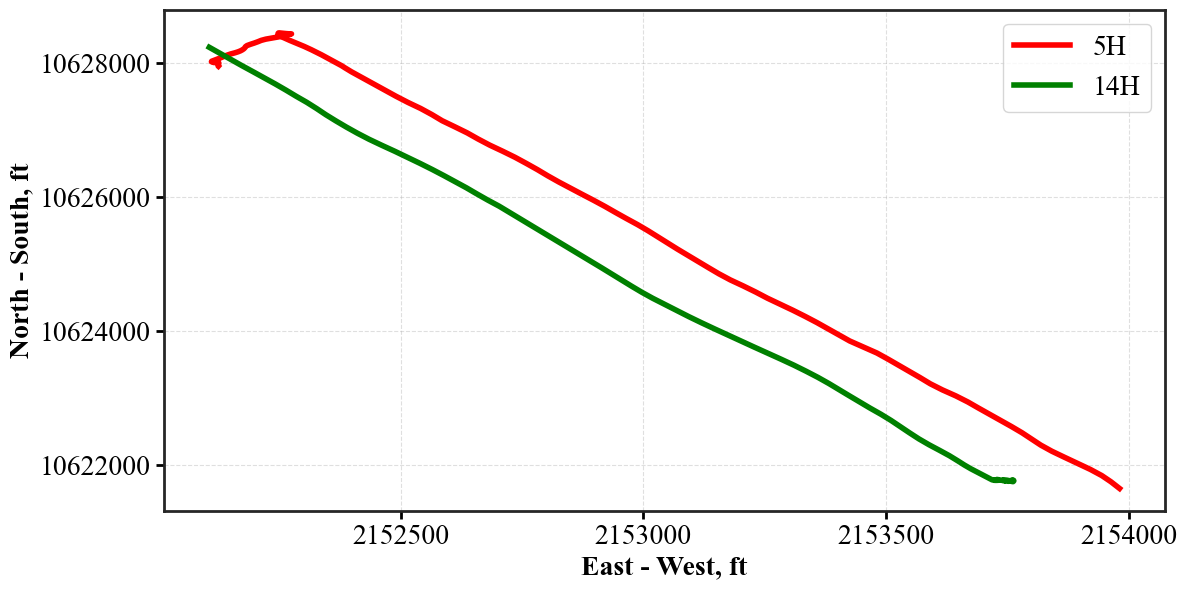

In [10]:
excel_path = r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/well_trajectory.xlsx"

fig2d, ax2d, cleaned2d = plot_selected_wells_2d(
    excel_path,
    wells=("5H", "14H"),
    sheet=0,                  # 单表默认 0；可改为具体 sheet 名
    # title="5H vs 14H — East–North",
    annotate_endpoints=False,
    legend_outside=False,
    color_map={"5H": "red", "14H": "green"}   # 或 {"5H":"#d62728","14H":"#2ca02c"}
)
ax2d.set_xticks([2152500,  2153000, 2153500, 2154000])
ax2d.set_yticks([10622000, 10624000, 10626000, 10628000])
plt.show()


In [1]:
2+1+2+1+2+2+3+4+5+2+1+3+3+4+5+4+3+1+2+4+3+2+2+1+3+4+2+4+1

76

# plot connection

In [7]:
%reload_ext autoreload
%autoreload 2

# === Imports & helpers ===
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Tuple, Union
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 统一列名（去空格、小写、映射常见字段）
_COL_MAP = {
    "uwi": "uwi",
    "alternateuwi": "alternateuwi",
    "wellname": "wellname",
    "w": "w",                  # ← 用它来分井
    "well": "well",
    "boreholename": "boreholename",
    "name": "name",
    "md": "md",
    "tvd": "tvd",
    "inc": "inc",
    "azm": "azm",
    "dx": "dx",
    "dy": "dy",
    "x": "x",
    "y": "y",
    "northref": "northref",
    "compmethod": "compmethod",
    "northdecl": "northdecl",
    "z": "z",
    "status": "status",
}

def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = []
    for c in df.columns:
        k = re.sub(r"\s+", "", str(c)).lower()
        new_cols.append(_COL_MAP.get(k, k))
    out = df.copy()
    out.columns = new_cols
    return out

def _coerce_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _reconstruct_xy(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """
    根据 x,y 或 dx,dy 生成平面轨迹。
    - 若 x,y 足够 → 直接返回
    - 否则用 dx,dy 做累积和；起点优先用首个有效 x/y，否则 (0,0)
    """
    # 内部按 MD 排序（若存在）
    if "md" in df.columns:
        df = df.sort_values("md", kind="mergesort")

    x = df["x"].to_numpy() if "x" in df.columns else np.full(len(df), np.nan)
    y = df["y"].to_numpy() if "y" in df.columns else np.full(len(df), np.nan)

    if np.isfinite(x).sum() >= 2 and np.isfinite(y).sum() >= 2:
        return x, y

    if "dx" in df.columns and "dy" in df.columns:
        dx = pd.to_numeric(df["dx"], errors="coerce").to_numpy()
        dy = pd.to_numeric(df["dy"], errors="coerce").to_numpy()
        x0 = float(x[np.isfinite(x)][0]) if np.isfinite(x).any() else 0.0
        y0 = float(y[np.isfinite(y)][0]) if np.isfinite(y).any() else 0.0
        X = x0 + np.nancumsum(np.nan_to_num(dx, nan=0.0))
        Y = y0 + np.nancumsum(np.nan_to_num(dy, nan=0.0))
        return X, Y

    raise ValueError("既无有效 x,y，也无 dx,dy，无法构建轨迹。")



# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (16, 5),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
    #   'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)


In [31]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_selected_wells_2d(
    source,
    wells=("5H", "14H"),
    *,
    sheet=None,
    title=None,
    annotate_endpoints=True,
    legend_outside=True,
    ax=None,
    color_map=None,   # {'5H':'red','14H':'green'}
    dash_by_md=None,           # ← 新增：{'14H': [(md1, md2), (md3, md4), ...]}
    dash_legend=None,          # ← 新增：{'14H': '14H — dashed (hit zone)', ...}
    # ↓↓↓ 新增：连线配置（可多个）
    links=None,       # e.g. [{'from':'14H','to':'5H','md':[12220,12324,...]}]
    link_color='0.5', link_lw=1.5, link_alpha=0.9, mark_link_points=True,
    connected_in_POP=None,     # ← 新增：MD 列表/字符串（14H→5H 的子集）
    pop_from='14H', pop_to='5H',
    pop_color='blue', pop_lw=2.0, pop_alpha=0.95,
    pop_mark_points=False,     # 是否在监测井端打点
    pop_legend='Connected in POP',  # 图例文字
):
    """
    只绘制列 w 中属于 wells 的井（2D：East–North），并可在指定 MD 处把两井用灰线连接。
    links: 列表，每项形如 {'from':'14H','to':'5H','md':[... 或 '12220, 12324, ...']}
    """

    # ---------- 小工具 ----------
    def _normalize_w(s):  # w 值统一到大写去空格
        return str(s).strip().upper()
    
    def _ensure_point(md, x, y, v):
        """在 (md,x,y) 的有序数组中插入 MD=v 的插值点（若 v 在范围内且不存在）。"""
        if not (md[0] < v < md[-1]):
            return md, x, y
        if np.any(np.isclose(md, v, rtol=0, atol=1e-9)):
            return md, x, y
        i = np.searchsorted(md, v)
        xi = np.interp(v, md, x)
        yi = np.interp(v, md, y)
        md2 = np.insert(md, i, v)
        x2  = np.insert(x,  i, xi)
        y2  = np.insert(y,  i, yi)
        return md2, x2, y2

    def _plot_with_dashes(ax, md, x, y, ranges, color, lw, *,
                        solid_label=None, dash_label=None):
        """
        按 ranges（MD 区间）把折线分段绘制：
        - 区间内：虚线（--），可用 dash_label（仅第一次出现时打label）
        - 区间外：实线（-），可用 solid_label（仅第一次出现时打label）
        返回 (solid_drawn, dash_drawn) 两个布尔值，表示是否画出了对应类型的片段。
        """
        md = np.asarray(md, float); x = np.asarray(x, float); y = np.asarray(y, float)
        keep = np.r_[True, np.diff(md) > 0]  # 去重&保证递增
        md, x, y = md[keep], x[keep], y[keep]
        if md.size < 2:
            return False, False

        def _ensure_point(md, x, y, v):
            if not (md[0] < v < md[-1]): return md, x, y
            if np.any(np.isclose(md, v, rtol=0, atol=1e-12)): return md, x, y
            i = np.searchsorted(md, v)
            xi = np.interp(v, md, x); yi = np.interp(v, md, y)
            return np.insert(md, i, v), np.insert(x, i, xi), np.insert(y, i, yi)

        # 插入所有区间端点，保证边界正好断在 lo/hi
        edges = []
        for lo, hi in ranges or []:
            if hi < md[0] or lo > md[-1]: continue
            lo = max(lo, md[0]); hi = min(hi, md[-1])
            if lo < hi: edges += [lo, hi]
        for v in sorted(set(edges)):
            md, x, y = _ensure_point(md, x, y, v)

        # 点是否处在虚线区
        mask_dash = np.zeros_like(md, dtype=bool)
        for lo, hi in ranges or []:
            lo = max(lo, md[0]); hi = min(hi, md[-1])
            if lo < hi:
                mask_dash |= (md >= lo) & (md <= hi)

        solid_done = False
        dash_done  = False
        change = np.r_[0, np.where(mask_dash[1:] != mask_dash[:-1])[0] + 1, md.size]
        for a, b in zip(change[:-1], change[1:]):
            if b - a < 2: 
                continue
            seg_x, seg_y = x[a:b], y[a:b]
            is_dash = bool(mask_dash[a])
            this_ls = '--' if is_dash else '-'
            this_label = None
            if is_dash and (not dash_done) and dash_label:
                this_label = dash_label; dash_done = True
            if (not is_dash) and (not solid_done) and solid_label:
                this_label = solid_label; solid_done = True
            ax.plot(seg_x, seg_y, color=color, lw=lw, ls=this_ls, label=this_label, zorder=3)
        return solid_done, dash_done

    def _reconstruct_xy(df: pd.DataFrame):
        # 你已有的函数；这里简写一份以自包含
        if "md" in df.columns:
            df = df.sort_values("md", kind="mergesort")
        X = df["x"].to_numpy() if "x" in df.columns else np.full(len(df), np.nan)
        Y = df["y"].to_numpy() if "y" in df.columns else np.full(len(df), np.nan)
        if np.isfinite(X).sum() >= 2 and np.isfinite(Y).sum() >= 2:
            return X, Y
        if "dx" in df.columns and "dy" in df.columns:
            dx = pd.to_numeric(df["dx"], errors="coerce").to_numpy()
            dy = pd.to_numeric(df["dy"], errors="coerce").to_numpy()
            x0 = float(X[np.isfinite(X)][0]) if np.isfinite(X).any() else 0.0
            y0 = float(Y[np.isfinite(Y)][0]) if np.isfinite(Y).any() else 0.0
            return x0 + np.nancumsum(np.nan_to_num(dx, nan=0.0)), \
                   y0 + np.nancumsum(np.nan_to_num(dy, nan=0.0))
        raise ValueError("既无有效 x,y，也无 dx,dy。")

    def _parse_md_list(md_values):
        # 支持 list/tuple/ndarray，或用逗号/空格分隔的字符串
        if md_values is None:
            return []
        if isinstance(md_values, (list, tuple, np.ndarray, pd.Series)):
            arr = np.asarray(md_values, dtype=float)
            return arr[np.isfinite(arr)].tolist()
        # 字符串
        txt = str(md_values).replace(';', ',').replace('，', ',')
        parts = [p for p in txt.replace('\n', ',').split(',') if p.strip()]
        vals = []
        for p in parts:
            try:
                vals.append(float(p))
            except Exception:
                pass
        return vals

    def _interp_xy_by_md(df_xy_md: pd.DataFrame, md_values):
        """在给定 md 上，线性插值得到 (x_plan,y_plan)。"""
        d = df_xy_md[['md','x_plan','y_plan']].dropna().sort_values('md')
        d = d[~d['md'].duplicated(keep='first')]
        if d.empty:
            return np.array([]), np.array([])
        md = d['md'].to_numpy()
        x  = d['x_plan'].to_numpy()
        y  = d['y_plan'].to_numpy()
        mds = np.asarray(md_values, dtype=float)
        xm = np.interp(mds, md, x, left=np.nan, right=np.nan)
        ym = np.interp(mds, md, y, left=np.nan, right=np.nan)
        return xm, ym

    def _closest_point_on_polyline(px, py, poly_x, poly_y):
        """点到折线最近点（逐段投影并截断到[0,1]）。"""
        qx = qy = np.nan
        best_d2 = np.inf
        for i in range(len(poly_x)-1):
            ax, ay = poly_x[i],   poly_y[i]
            bx, by = poly_x[i+1], poly_y[i+1]
            vx, vy = bx-ax, by-ay
            wx, wy = px-ax, py-ay
            vv = vx*vx + vy*vy
            t = 0.0 if vv == 0 else (wx*vx + wy*vy) / vv
            t = 0.0 if t < 0 else (1.0 if t > 1.0 else t)
            qxi = ax + t*vx
            qyi = ay + t*vy
            d2  = (px-qxi)**2 + (py-qyi)**2
            if d2 < best_d2:
                best_d2 = d2; qx, qy = qxi, qyi
        return qx, qy, np.sqrt(best_d2)

    # ---------- 读取并画两口井 ----------
    if isinstance(source, (str, Path)):
        df = pd.read_excel(source, sheet_name=sheet if sheet is not None else 0, engine="openpyxl")
    elif isinstance(source, pd.DataFrame):
        df = source.copy()
    else:
        raise TypeError("source 必须是 Excel 路径或 pandas.DataFrame")

    df = _normalize_columns(df)
    df = _coerce_numeric(df, ["md", "tvd", "inc", "azm", "dx", "dy", "x", "y", "z"])

    if "w" not in df.columns:
        raise ValueError("未找到列 'w'。")

    want = {_normalize_w(w) for w in wells}
    df["_w_norm"] = df["w"].astype(str).str.strip().str.upper()
    df_sel = df[df["_w_norm"].isin(want)].copy()
    if df_sel.empty:
        raise ValueError(f"在列 w 中未找到 {sorted(want)}")

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = ax.figure

    colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [f"C{i}" for i in range(10)])
    cleaned = {}
    norm_cmap = {} if color_map is None else { _normalize_w(k): v for k, v in color_map.items() }
    dash_map = {} if dash_by_md is None else { _normalize_w(k): v for k, v in dash_by_md.items() }
    dash_label_map = {} if dash_legend is None else { _normalize_w(k): v for k, v in dash_legend.items() }
    order = [w for w in wells if _normalize_w(w) in df_sel["_w_norm"].unique()]

    for i, wv in enumerate(order):
        dfg = df_sel[df_sel["_w_norm"] == _normalize_w(wv)].copy()
        if "md" in dfg.columns:
            dfg = dfg.sort_values("md", kind="mergesort")

        X, Y = _reconstruct_xy(dfg)
        mask = np.isfinite(X) & np.isfinite(Y)
        if mask.sum() < 2:
            print(f"[WARN] 井 {wv} 有效点不足。"); continue

        xx, yy = X[mask], Y[mask]
        dclean = dfg.loc[mask].copy()
        dclean["x_plan"], dclean["y_plan"] = xx, yy
        cleaned[_normalize_w(wv)] = dclean

        color = norm_cmap.get(_normalize_w(wv), colors[i % len(colors)])
        # —— 核心：是否需要虚线区间 —— #
        ranges = dash_map.get(_normalize_w(wv))
        if ranges and "md" in dclean.columns:
            md_arr = dclean["md"].to_numpy()
            # 自定义虚线图例文字；也可用一个字典参数 dash_legend 来映射每口井
            dash_lbl = dash_label_map.get(_normalize_w(wv), f"{wv} — dashed")
            solid_done, dash_done = _plot_with_dashes(
                ax, md_arr, xx, yy, ranges, color=color, lw=4,
                solid_label=str(wv), dash_label=dash_lbl
            )
            # 若不存在实线片段，放一个代理 handle 保证“14H（实线）”仍在图例里
            if not solid_done:
                ax.plot([], [], color=color, lw=4, ls='-', label=str(wv))
            # 若不存在虚线片段（边界恰好等于端点等少见情况），也放代理
            if not dash_done and dash_lbl:
                ax.plot([], [], color=color, lw=4, ls='--', label=dash_lbl)
        else:
            ax.plot(xx, yy, lw=4, color=color, label=str(wv))

        if annotate_endpoints:
            ax.scatter([xx[-1]], [yy[-1]], s=24, color=color, zorder=5)
            ax.annotate(str(wv), xy=(xx[-1], yy[-1]), xytext=(6, 6),
                        textcoords="offset points", fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.6))
        

    if not cleaned:
        raise ValueError("没有可绘制的井。")

    # ---------- 画连通线 ----------
    if links:
        for spec in links:
            from_w = _normalize_w(spec.get('from'))
            to_w   = _normalize_w(spec.get('to'))
            md_list = _parse_md_list(spec.get('md'))

            if from_w not in cleaned or to_w not in cleaned:
                print(f"[WARN] 连线跳过：'{from_w}' 或 '{to_w}' 不在已绘制井中。")
                continue
            if not md_list:
                print(f"[WARN] 连线跳过：'{from_w}' 没有有效 MD。")
                continue

            df_from = cleaned[from_w]
            df_to   = cleaned[to_w]
            if "md" not in df_from.columns:
                print(f"[WARN] 连线跳过：'{from_w}' 缺少 md 列。")
                continue

            xM, yM = _interp_xy_by_md(df_from, md_list)
            poly_x = df_to['x_plan'].to_numpy()
            poly_y = df_to['y_plan'].to_numpy()

            drawn = 0
            for xm, ym in zip(xM, yM):
                if not (np.isfinite(xm) and np.isfinite(ym)):
                    continue
                xt, yt, _ = _closest_point_on_polyline(xm, ym, poly_x, poly_y)
                ax.plot([xt, xm], [yt, ym],
                        color=link_color, lw=link_lw, alpha=link_alpha, zorder=2)
                if mark_link_points:
                    ax.scatter([xm], [ym], s=14, color=link_color, zorder=3)
                drawn += 1
            print(f"[OK] {from_w} → {to_w} 连线 {drawn} 条。")

    # ---------- 画 POP 子集（蓝色连通线） ----------
    if connected_in_POP is not None:
        from_w = _normalize_w(pop_from)
        to_w   = _normalize_w(pop_to)
        md_list = _parse_md_list(connected_in_POP)

        if from_w not in cleaned or to_w not in cleaned:
            print(f"[WARN] POP 连线跳过：'{from_w}' 或 '{to_w}' 不在已绘制井中。")
        elif not md_list:
            print("[WARN] POP 连线跳过：没有有效的 MD 列表。")
        else:
            df_from = cleaned[from_w]
            df_to   = cleaned[to_w]
            if "md" not in df_from.columns:
                print(f"[WARN] POP 连线跳过：'{from_w}' 缺少 md 列。")
            else:
                xM, yM = _interp_xy_by_md(df_from, md_list)
                poly_x = df_to['x_plan'].to_numpy()
                poly_y = df_to['y_plan'].to_numpy()

                drawn_pop = 0
                for xm, ym in zip(xM, yM):
                    if not (np.isfinite(xm) and np.isfinite(ym)):
                        continue
                    xt, yt, _ = _closest_point_on_polyline(xm, ym, poly_x, poly_y)
                    ax.plot([xt, xm], [yt, ym],
                            color=pop_color, lw=pop_lw, alpha=pop_alpha, zorder=3,
                            label=None)
                    if pop_mark_points:
                        ax.scatter([xm], [ym], s=16, color=pop_color, zorder=4)
                    drawn_pop += 1

                # 给 POP 连线加一个图例项（代理 handle，避免重复）
                if drawn_pop > 0 and pop_legend:
                    ax.plot([], [], color=pop_color, lw=pop_lw, alpha=pop_alpha,
                            label=pop_legend)
                print(f"[OK] POP 连线 {from_w} → {to_w} ：{drawn_pop} 条。")



    # ---------- 轴样式 ----------
    ax.set_xlabel("East - West, ft")
    ax.set_ylabel("North - South, ft")
    ax.grid(True, ls="--", alpha=0.4)
    ax.ticklabel_format(style='plain', useOffset=False, axis='both')

    if legend_outside:
        leg = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True)
        fig.subplots_adjust(right=0.80)
    else:
        ax.legend(loc='best')

    if title:
        ax.set_title(title)

    plt.tight_layout()
    return fig, ax, cleaned


[OK] 14H → 5H 连线 57 条。
[OK] POP 连线 14H → 5H ：17 条。


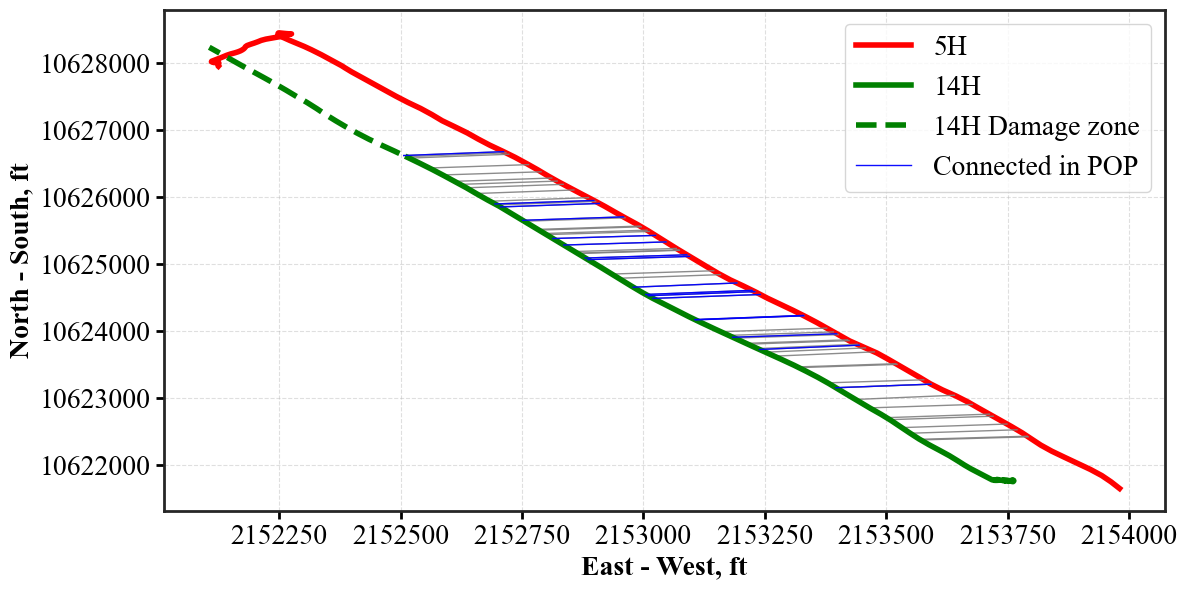

In [54]:
excel_path = r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/well_trajectory.xlsx"

hits_md_14H = """
12220,12324,12230,12410,12562,12531,12712,12841,
13020,13096,13021,13342,13331,13510,13572,13614,13697,
13710,13792,13805,13834,13892,13628,14076,14081,
14409,14450,14470,14582,14720,14785,15007,15032,15101,15132,
15107,15232,15332,15392,15461,15409,15472,15597,15611,
15816,15862,15904,15847,16023,16111,16164,16211,16310,16418,16594,
16572,16612,
"""
# 16678,16701,16192,16923,16994,17020,17172,17210,17279,17307,
# 17432,17501,17557,17611,17694,17832,17910

# fig2d, ax2d, cleaned2d = plot_selected_wells_2d(
#     excel_path,
#     wells=("5H", "14H"),
#     sheet=0,
#     annotate_endpoints=False,
#     legend_outside=False,
#     color_map={"5H": "red", "14H": "green"},
#     dash_by_md={"14H": [(16644, 99990)]},  # ← 这里填你需要变成虚线的 MD 区间(可多个)
#     links= [{"from": "14H", "to": "5H", "md": hits_md_14H}],  # ← 这里加上连线
#     link_color='0.5', link_lw=1, link_alpha=0.9, mark_link_points=False,
#     dash_legend={"14H":"14H Damage zone"}   # ← 新增映射
# )

# ax2d.set_xticks([2152500, 2153000, 2153500, 2154000])
# ax2d.set_yticks([10622000, 10624000, 10626000, 10628000])
# plt.show()
connected_in_POP = """
16612,15816,15862,15611,15332,15232,15007,15032,14470,14582,14409,14450,14076,14081,13805,13614,13021
"""  # ← hits_md_14H 的子集

fig2d, ax2d, cleaned2d = plot_selected_wells_2d(
    excel_path,
    wells=("5H", "14H"),
    sheet=0,
    annotate_endpoints=False,
    legend_outside=False,
    color_map={"5H":"red","14H":"green"},
    dash_by_md={"14H":[(16644, 99990)]},
    links=[{"from":"14H","to":"5H","md":hits_md_14H}],   # 灰色：全部 hits
    link_color='0.5', link_lw=1, link_alpha=0.9, mark_link_points=False,
    dash_legend={"14H":"14H Damage zone"},   # ← 新增映射
    connected_in_POP=connected_in_POP,                  # 蓝色：POP 子集
    pop_from='14H', pop_to='5H',
    pop_color='blue', pop_lw=1, pop_alpha=0.95,
    pop_mark_points=False,
    pop_legend='Connected in POP'
)
plt.show()